In [34]:

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from kneed import KneeLocator
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st


In [35]:
params_weak = pd.read_csv("params_weak.csv")
params_fix = pd.read_csv("params_fix.csv")
params_chang = pd.read_csv("params_chang.csv")
params_weak["treatment"] = "weak"
params_chang["treatment"] = "chang"
params_fix["treatment"] = "fix"
params_1 = pd.read_csv("params_1.csv")
params_1.rename(columns = {"userid":"user"}, inplace = True)
params_2 = pd.read_csv("params_2.csv")
params_2.rename(columns = {"userid":"user"}, inplace = True)
params_c = pd.read_csv("params_c.csv")
params_c.rename(columns = {"userid":"user"}, inplace = True)
actions = pd.read_csv("actions.csv")


In [36]:
params_1.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'user', 'a', 'v', 't', 'z', 'a_st10',
       'v_st10', 't_st10', 'z_st10', 'a10', 'v10', 't10', 'z10', 'a_st0',
       'v_st0', 't_st0', 'z_st0', 'a0', 'v0', 't0', 'z0', 'a_st20', 'v_st20',
       't_st20', 'z_st20', 'a20', 'v20', 't20', 'z20', 'a_st30', 'v_st30',
       't_st30', 'z_st30', 'a30', 'v30', 't30', 'z30', 'a_st40', 'v_st40',
       't_st40', 'z_st40', 'a40', 'v40', 't40', 'z40', 's2', 's1'],
      dtype='object')

In [37]:
#Receives a list of players to show
def get_params(param, players, treatment, start = 1, columns = 11):
    param_cols = ["%s%d" % t for t in zip([param] * 10, [x*10 for x in range(start, columns)])]
    param_sd = ["%s_st%d" % t for t in zip([param] * 10, [x*10 for x in range(start, columns)])] 
    params = pd.melt(treatment.loc[treatment.user.isin(players)], id_vars=['user'], value_vars = param_cols)
    sds = pd.melt(treatment.loc[treatment.user.isin(players)], id_vars=['user'], value_vars = param_sd)
    d = params.groupby("variable").mean()
    d.index = pd.to_numeric(d.index.str.replace(param, ""))
    d_sd = sds.groupby("variable").mean()
    d_sd.index = pd.to_numeric(d_sd.index.str.replace("%s_st" % (param), ""))
    d_sd["round"] = d_sd.index
    d["round"] = d.index
    d = d.merge(d_sd, on = "round")
    d = d.sort_values(by="round")
    d.rename(columns = {"value_x":param, "value_y":"std"}, inplace=True)
    return d

In [38]:
pair_colors = {"fix":"#f03b20", "random":"#feb24c", "weak":"#1c9099"}
pair_symbols = {"fix":"D", "random":"o", "weak":"s"}

net_colors = {1:"#14910d", 2:"#022175", "c":"#04d197"}
net_symbols = {1:"^", 2:"v", "c":"o"}

plt.rcParams.update({'font.size': 18})

<Figure size 720x720 with 0 Axes>

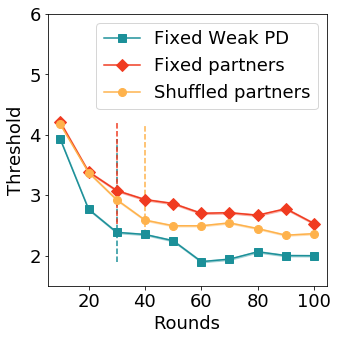

In [60]:
param = "a"

curve_w = params_weak.mean()[["%s%d" % t for t in zip([param] * 10, [x*10 for x in range(1, 10+1)])]]
curve_f = params_fix.mean()[["%s%d" % t for t in zip([param] * 10, [x*10 for x in range(1, 10+1)])]]
curve_c = params_chang.mean()[["%s%d" % t for t in zip([param] * 10, [x*10 for x in range(1, 10+1)])]]

knee_w = KneeLocator(list(range(10,110, 10)), curve_w, S=1.0, curve="convex", direction="decreasing")
knee_f = KneeLocator(list(range(10,110, 10)), curve_f, S=1.0, curve="convex", direction="decreasing")
knee_c = KneeLocator(list(range(10,110, 10)), curve_c, S=1.0, curve="convex", direction="decreasing")

weak = get_params(param, actions.user, params_weak)
chang = get_params(param, actions.user, params_chang)
fix = get_params(param, actions.user, params_fix)

errWeak = weak["std"] / np.sqrt(5000)
errChang = chang["std"] / np.sqrt(5000)
errFix = fix["std"] / np.sqrt(5000)


plt.figure(figsize = (10,10))
plt.figure(figsize=(5,5))
plt.plot(weak["round"], weak[param],"-o",label = "Fixed Weak PD", color = pair_colors["weak"], marker = pair_symbols["weak"], markersize=8)
plt.plot(fix["round"], fix[param],"-o",label = "Fixed partners", color = pair_colors["fix"], marker = pair_symbols["fix"], markersize=8)
plt.plot(chang["round"], chang[param],"-o",label = "Shuffled partners", color = pair_colors["random"], marker = pair_symbols["random"], markersize=8)
plt.fill_between(weak["round"], weak[param] + (errWeak * 1.96), weak[param] - (errWeak * 1.96), alpha = 0.3, color = pair_colors["weak"])
plt.fill_between(fix["round"], fix[param] + (errFix * 1.96), fix[param] - (errFix * 1.96), alpha = 0.3, color = pair_colors["fix"])
plt.fill_between(chang["round"], chang[param] + (errChang * 1.96), chang[param] - (errChang * 1.96), alpha = 0.3, color = pair_colors["random"])
plt.vlines(knee_w.knee, weak[param].min(), weak[param].max(), linestyles="--", color = pair_colors["weak"])
plt.vlines(knee_f.knee, fix[param].min(), fix[param].max(), linestyles="--", color = pair_colors["fix"])
plt.vlines(knee_c.knee, chang[param].min(), chang[param].max(), linestyles="--", color = pair_colors["random"])
plt.xlabel("Rounds")
plt.ylabel("Threshold")
plt.ylim(1.5, 6)
plt.legend()

In [40]:
def plot_param (treatment, param, score, absolute = False):
    params = {"fix":params_fix,"chang":params_chang, "weak":params_weak}
    param_set = params[treatment]
    if absolute:
        param_values = np.abs(param_set[param])
    else: param_values = param_set[param]
    plt.scatter(param_set[score], param_values)
    plt.title("%f, %f" % st.pearsonr(param_set[score], param_values))

In [41]:
interact(plot_param, treatment=[('fix', "fix"), ('changing', "chang"), ('weak', "weak")], 
         param = [('Threshold', "a"), ('Drift Speed', 'v'), ('Bias', 'z')], 
         score= [('s1', "score"), ('s2', "score_adj")])

interactive(children=(Dropdown(description='treatment', options=(('fix', 'fix'), ('changing', 'chang'), ('weak…

<function __main__.plot_param(treatment, param, score, absolute=False)>

<Figure size 720x720 with 0 Axes>

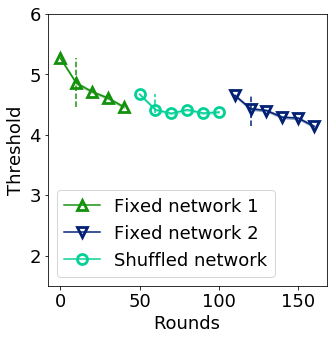

In [63]:
param = "a"

curve_1 = params_1.mean()[["%s%d" % t for t in zip([param] * 10, [x*10 for x in range(0, 5)])]]
curve_2 = params_2.mean()[["%s%d" % t for t in zip([param] * 10, [x*10 for x in range(0, 6)])]]
curve_c = params_c.mean()[["%s%d" % t for t in zip([param] * 10, [x*10 for x in range(0, 6)])]]
knee_1 = KneeLocator(list(range(0,50, 10)), curve_1, S=1.0, curve="convex", direction="decreasing")
knee_2 = KneeLocator(list(range(0,60, 10)), curve_2, S=1.0, curve="concave", direction="decreasing")
knee_c = KneeLocator(list(range(0,60, 10)), curve_c, S=1.0, curve="convex", direction="decreasing")



net_1 = get_params(param, params_1.user.unique(), params_1, start = 0, columns = 5)
net_2 = get_params(param, params_2.user.unique(), params_2, start = 0,columns = 6)
net_c = get_params(param, params_c.user.unique(), params_c, start = 0,columns = 6)

#net_1["round"] = net_1["round"] + 10
net_c["round"] = net_c["round"] + net_1["round"].max() + 10
net_2["round"] = net_2["round"] + net_c["round"].max() + 10

err1 = net_1["std"] / np.sqrt(5000)
err2 = net_2["std"] / np.sqrt(5000)
errc = net_c["std"] / np.sqrt(5000)
plt.figure(figsize = (10,10))
plt.figure(figsize=(5,5))
plt.plot(net_1["round"], net_1[param],"-o",label = "Fixed network 1", color = net_colors[1], marker = net_symbols[1], fillstyle = "none", markersize = 10, markeredgewidth = 2.8)
plt.plot(net_2["round"], net_2[param],"-o",label = "Fixed network 2", color = net_colors[2], marker = net_symbols[2], fillstyle = "none", markersize = 10, markeredgewidth = 2.8)
plt.plot(net_c["round"], net_c[param],"-o",label = "Shuffled network", color = net_colors["c"], marker = net_symbols["c"], fillstyle = "none", markersize = 10, markeredgewidth = 2.8)

plt.fill_between(net_1["round"], net_1[param] + (err1 * 1.96), net_1[param] - (err1 * 1.96), alpha = 0.3, color = net_colors[1])
plt.fill_between(net_2["round"], net_2[param] + (err2 * 1.96), net_2[param] - (err2 * 1.96), alpha = 0.3, color = net_colors[2])
plt.fill_between(net_c["round"], net_c[param] + (err2 * 1.96), net_c[param] - (err2 * 1.96), alpha = 0.3, color = net_colors["c"])
plt.vlines(knee_1.knee, net_1[param].min(), net_1[param].max(), linestyles="--", color = net_colors[1])
plt.vlines(knee_c.knee + net_1["round"].max() + 10, net_c[param].min(), net_c[param].max(), linestyles="--", color = net_colors["c"])
plt.vlines(120, net_2[param].min(), net_2[param].max(), linestyles="--", color = net_colors[2])
plt.xlabel("Rounds")
plt.ylabel("Threshold")
plt.ylim(1.5, 6)
plt.legend()

<Figure size 720x720 with 0 Axes>

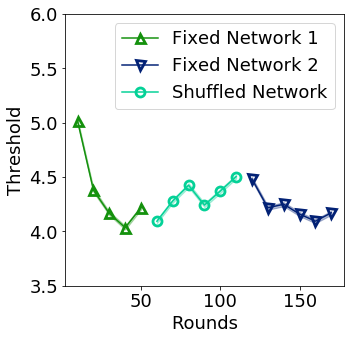

In [64]:
param = "a"
net_1 = get_params(param, params_1.loc[params_1.s2 >= 500, "user"], params_1, start = 0,columns = 5)
net_2 = get_params(param, params_1.loc[params_2.s2 >= 500, "user"], params_2, start = 0,columns = 6)
net_c = get_params(param, params_1.loc[params_1.s2 >= 500, "user"], params_c, start = 0,columns = 6)

net_1["round"] = net_1["round"] + 10
net_c["round"] = net_c["round"] + net_1["round"].max() + 10
net_2["round"] = net_2["round"] + net_c["round"].max() + 10

err1 = net_1["std"] / np.sqrt(5000)
err2 = net_2["std"] / np.sqrt(5000)
errc = net_c["std"] / np.sqrt(5000)
plt.figure(figsize = (10,10))
plt.figure(figsize=(5,5))
plt.plot(net_1["round"], net_1[param],"-o",label = "Fixed Network 1", color = net_colors[1], marker = net_symbols[1], fillstyle = "none", markersize = 9, markeredgewidth = 2.8)
plt.plot(net_2["round"], net_2[param],"-o",label = "Fixed Network 2", color = net_colors[2], marker = net_symbols[2], fillstyle = "none", markersize = 9, markeredgewidth = 2.8)
plt.plot(net_c["round"], net_c[param],"-o",label = "Shuffled Network", color = net_colors["c"], marker = net_symbols["c"], fillstyle = "none", markersize = 9, markeredgewidth = 2.8)



plt.fill_between(net_1["round"], net_1[param] + (err1 * 1.96), net_1[param] - (err1 * 1.96), alpha = 0.3, color = net_colors[1])
plt.fill_between(net_2["round"], net_2[param] + (err2 * 1.96), net_2[param] - (err2 * 1.96), alpha = 0.3, color = net_colors[2])
plt.fill_between(net_c["round"], net_c[param] + (err2 * 1.96), net_c[param] - (err2 * 1.96), alpha = 0.3, color = net_colors["c"])

plt.ylim(3.5, 6)
plt.xlabel("Rounds")
plt.ylabel("Threshold")
plt.legend()

Text(0, 0.5, 'Threshold')

<Figure size 720x720 with 0 Axes>

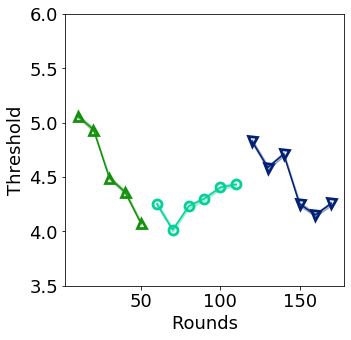

In [65]:
param = "a"
net_1 = get_params(param, params_1.loc[np.abs(params_1.s2) <= 32, "user"], params_1,start = 0, columns = 5)
net_2 = get_params(param, params_1.loc[np.abs(params_2.s2) <= 32, "user"], params_2,start = 0, columns = 6)
net_c = get_params(param, params_1.loc[np.abs(params_1.s2) <= 32, "user"], params_c,start = 0, columns = 6)

net_1["round"] = net_1["round"] + 10
net_c["round"] = net_c["round"] + net_1["round"].max() + 10
net_2["round"] = net_2["round"] + net_c["round"].max() + 10

err1 = net_1["std"] / np.sqrt(5000)
err2 = net_2["std"] / np.sqrt(5000)
errc = net_c["std"] / np.sqrt(5000)
plt.figure(figsize = (10,10))
plt.figure(figsize=(5,5))
plt.plot(net_1["round"], net_1[param],"-o",label = "Fixed Network 1", color = net_colors[1], marker = net_symbols[1], fillstyle = "none", markersize = 9, markeredgewidth = 2.8)
plt.plot(net_2["round"], net_2[param],"-o",label = "Fixed Network 2", color = net_colors[2], marker = net_symbols[2], fillstyle = "none", markersize = 9, markeredgewidth = 2.8)
plt.plot(net_c["round"], net_c[param],"-o",label = "Shuffled network", color = net_colors["c"], marker = net_symbols["c"], fillstyle = "none", markersize = 9, markeredgewidth = 2.8)

plt.fill_between(net_1["round"], net_1[param] + (err1 * 1.96), net_1[param] - (err1 * 1.96), alpha = 0.3, color = net_colors[1])
plt.fill_between(net_2["round"], net_2[param] + (err2 * 1.96), net_2[param] - (err2 * 1.96), alpha = 0.3, color = net_colors[2])
plt.fill_between(net_c["round"], net_c[param] + (err2 * 1.96), net_c[param] - (err2 * 1.96), alpha = 0.3, color = net_colors["c"])
plt.ylim(3.5, 6)
plt.xlabel("Rounds")
plt.ylabel("Threshold")
#plt.legend()

Text(0, 0.5, 'Threshold')

<Figure size 720x720 with 0 Axes>

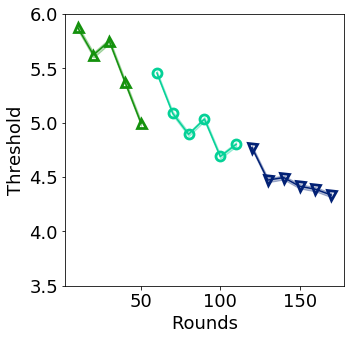

In [66]:
param = "a"
net_1 = get_params(param, params_1.loc[params_1.s2 < -500, "user"], params_1,start = 0, columns = 5)
net_2 = get_params(param, params_1.loc[params_2.s2 < -500, "user"], params_2,start = 0, columns = 6)
net_c = get_params(param, params_1.loc[params_1.s2 < -500, "user"], params_c,start = 0, columns = 6)

net_1["round"] = net_1["round"] + 10
net_c["round"] = net_c["round"] + net_1["round"].max() + 10
net_2["round"] = net_2["round"] + net_c["round"].max() + 10

err1 = net_1["std"] / np.sqrt(5000)
err2 = net_2["std"] / np.sqrt(5000)
errc = net_c["std"] / np.sqrt(5000)
plt.figure(figsize = (10,10))
plt.figure(figsize=(5,5))
plt.plot(net_1["round"], net_1[param],"-o",label = "Fixed Network 1", color = net_colors[1], marker = net_symbols[1], fillstyle = "none", markersize = 9, markeredgewidth = 2.8)
plt.plot(net_2["round"], net_2[param],"-o",label = "Fixed Network 2", color = net_colors[2], marker = net_symbols[2], fillstyle = "none", markersize = 9, markeredgewidth = 2.8)
plt.plot(net_c["round"], net_c[param],"-o",label = "Shuffled network", color = net_colors["c"], marker = net_symbols["c"], fillstyle = "none", markersize = 9, markeredgewidth = 2.8)

plt.fill_between(net_1["round"], net_1[param] + (err1 * 1.96), net_1[param] - (err1 * 1.96), alpha = 0.3, color = net_colors[1])
plt.fill_between(net_2["round"], net_2[param] + (err2 * 1.96), net_2[param] - (err2 * 1.96), alpha = 0.3, color = net_colors[2])
plt.fill_between(net_c["round"], net_c[param] + (err2 * 1.96), net_c[param] - (err2 * 1.96), alpha = 0.3, color = net_colors["c"])
plt.ylim(3.5, 6)
plt.xlabel("Rounds")
plt.ylabel("Threshold")
#plt.legend()

(array([ 1.,  1.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  2.,  0.,  2.,
         3., 12., 22.,  4.,  2.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,
         0.,  0.,  1.,  1.]),
 array([-236. , -220.4, -204.8, -189.2, -173.6, -158. , -142.4, -126.8,
        -111.2,  -95.6,  -80. ,  -64.4,  -48.8,  -33.2,  -17.6,   -2. ,
          13.6,   29.2,   44.8,   60.4,   76. ,   91.6,  107.2,  122.8,
         138.4,  154. ,  169.6,  185.2,  200.8,  216.4,  232. ]),
 <a list of 30 Patch objects>)

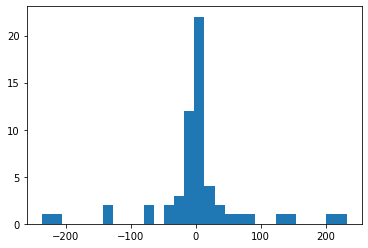

In [8]:
#Pro-socials = neutral 
#Pushing for certain interpretation, it should be clear by looking at the data. 
#Avoid the labeling.
#Explain the s2 data, avoid SVO
#What does it mean to be in the positive spectrum/near zero/negative
plt.hist(params_chang.score_adj, bins = 30)


(array([ 1.,  3.,  8.,  6.,  7.,  9., 10.,  4.,  8., 14., 18., 13., 18.,
         8., 12.,  6.,  7.,  1.,  4.,  0.,  1.,  3.,  1.,  0.,  2.,  2.,
         0.,  2.,  0.,  1.]),
 array([-704.        , -641.23333333, -578.46666667, -515.7       ,
        -452.93333333, -390.16666667, -327.4       , -264.63333333,
        -201.86666667, -139.1       ,  -76.33333333,  -13.56666667,
          49.2       ,  111.96666667,  174.73333333,  237.5       ,
         300.26666667,  363.03333333,  425.8       ,  488.56666667,
         551.33333333,  614.1       ,  676.86666667,  739.63333333,
         802.4       ,  865.16666667,  927.93333333,  990.7       ,
        1053.46666667, 1116.23333333, 1179.        ]),
 <a list of 30 Patch objects>)

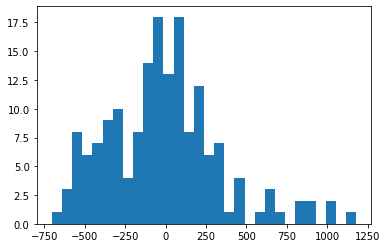

In [11]:
plt.hist(params_1.s2, bins = 30)

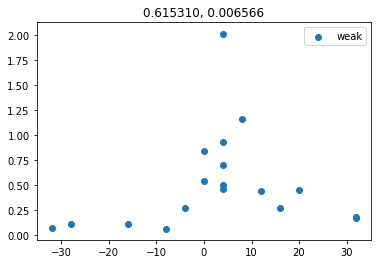

In [22]:
plt.scatter(params_weak.score_adj, np.abs(params_weak.v), label = "weak")
plt.title("%f, %f" % st.pearsonr(params_weak.score, params_weak.v))
plt.legend()

In [9]:
param_names = {"a": "Threshold", "v":"Drift Speed", "z": "Threshold"}

<Figure size 720x720 with 0 Axes>

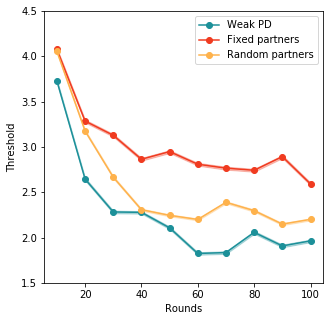

In [10]:
param = "a"

soc_fix = get_params(param, actions.loc[actions.type_adj == "Pro-social", "user"], params_fix)
soc_ch = get_params(param, actions.loc[actions.type_adj == "Pro-social", "user"], params_chang)
soc_we = get_params(param, actions.loc[actions.type_adj == "Pro-social", "user"], params_weak)
errWeak = soc_we["std"] / np.sqrt(5000)
errChang = soc_ch["std"] / np.sqrt(5000)
errFix = soc_fix["std"] / np.sqrt(5000)

plt.figure(figsize = (10,10))
plt.figure(figsize=(5,5))
plt.plot(soc_we["round"], soc_we[param],"-o",label = "Weak PD", color = pair_colors["weak"])
plt.plot(soc_fix["round"], soc_fix[param],"-o",label = "Fixed partners", color = pair_colors["fix"])
plt.plot(soc_ch["round"], soc_ch[param],"-o",label = "Shuffled partners", color = pair_colors["random"])
plt.fill_between(soc_we["round"], soc_we[param] + (errWeak * 1.96), soc_we[param] - (errWeak * 1.96), alpha = 0.3, color = pair_colors["weak"])
plt.fill_between(soc_fix["round"], soc_fix[param] + (errFix * 1.96), soc_fix[param] - (errFix * 1.96), alpha = 0.3, color = pair_colors["fix"])
plt.fill_between(soc_ch["round"], soc_ch[param] + (errChang * 1.96), soc_ch[param] - (errChang * 1.96), alpha = 0.3, color = pair_colors["random"])
plt.xlabel("Rounds")
plt.ylabel(param_names[param])
plt.ylim(1.5, 4.5)
plt.legend()

<Figure size 720x720 with 0 Axes>

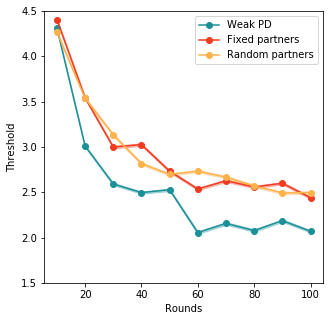

In [11]:
param = "a"
selfix = get_params(param, actions.loc[actions.type_adj == "Pro-self", "user"], params_fix)
selch = get_params(param, actions.loc[actions.type_adj == "Pro-self", "user"], params_chang)
selwe = get_params(param, actions.loc[actions.type_adj == "Pro-self", "user"], params_weak)
errWeak = selwe["std"] / np.sqrt(5000)
errChang = selch["std"] / np.sqrt(5000)
errFix = selfix["std"] / np.sqrt(5000)

plt.figure(figsize = (10,10))
plt.figure(figsize=(5,5))
plt.plot(selwe["round"], selwe[param],"-o",label = "Weak PD", color = pair_colors["weak"])
plt.plot(selfix["round"], selfix[param],"-o",label = "Fixed partners", color  = pair_colors["fix"])
plt.plot(selch["round"], selch[param],"-o",label = "Shuffled partners", color =  pair_colors["random"])
plt.fill_between(selwe["round"], selwe[param] + (errWeak * 1.96), selwe[param] - (errWeak * 1.96), alpha = 0.3, color =  pair_colors["weak"])
plt.fill_between(selfix["round"], selfix[param] + (errFix * 1.96), selfix[param] - (errFix * 1.96), alpha = 0.3, color  = pair_colors["fix"])
plt.fill_between(selch["round"], selch[param] + (errChang * 1.96), selch[param] - (errChang * 1.96), alpha = 0.3, color  = pair_colors["random"])
plt.xlabel("Rounds")
plt.ylabel(param_names[param])
plt.ylim(1.5, 4.5)
plt.legend()

(1.5, 6)

<Figure size 720x720 with 0 Axes>

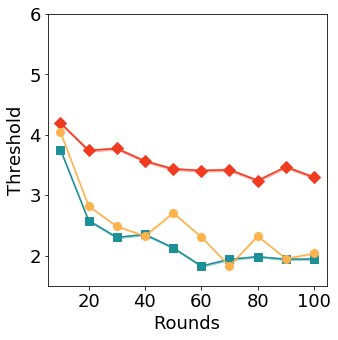

In [28]:

curve_w = params_weak.mean()[["%s%d" % t for t in zip([param] * 10, [x*10 for x in range(1, 10+1)])]]
curve_f = params_fix.mean()[["%s%d" % t for t in zip([param] * 10, [x*10 for x in range(1, 10+1)])]]
curve_c = params_chang.mean()[["%s%d" % t for t in zip([param] * 10, [x*10 for x in range(1, 10+1)])]]

knee_w = KneeLocator(list(range(10,110, 10)), curve_w, S=1.0, curve="convex", direction="decreasing")
knee_f = KneeLocator(list(range(10,110, 10)), curve_f, S=1.0, curve="convex", direction="decreasing")
knee_c = KneeLocator(list(range(10,110, 10)), curve_c, S=1.0, curve="convex", direction="decreasing")

weak = get_params(param, actions.loc[np.abs(actions["score_adj"]) <= 5, "user"], params_weak)
chang = get_params(param, actions.loc[np.abs(actions["score_adj"]) <= 5, "user"], params_chang)
fix = get_params(param, actions.loc[np.abs(actions["score_adj"]) <= 5, "user"], params_fix)

errWeak = weak["std"] / np.sqrt(5000)
errChang = chang["std"] / np.sqrt(5000)
errFix = fix["std"] / np.sqrt(5000)


plt.figure(figsize = (10,10))
plt.figure(figsize=(5,5))
plt.plot(weak["round"], weak[param],"-o",label = "Weak PD", color = pair_colors["weak"], marker = pair_symbols["weak"], markersize=8)
plt.plot(fix["round"], fix[param],"-o",label = "Fixed partners", color = pair_colors["fix"], marker = pair_symbols["fix"], markersize=8)
plt.plot(chang["round"], chang[param],"-o",label = "Shuffled partners", color = pair_colors["random"], marker = pair_symbols["random"], markersize=8)
plt.fill_between(weak["round"], weak[param] + (errWeak * 1.96), weak[param] - (errWeak * 1.96), alpha = 0.3, color = pair_colors["weak"])
plt.fill_between(fix["round"], fix[param] + (errFix * 1.96), fix[param] - (errFix * 1.96), alpha = 0.3, color = pair_colors["fix"])
plt.fill_between(chang["round"], chang[param] + (errChang * 1.96), chang[param] - (errChang * 1.96), alpha = 0.3, color = pair_colors["random"])
plt.xlabel("Rounds")
plt.ylabel("Threshold")
plt.ylim(1.5, 6)
#plt.legend()

(1.5, 6)

<Figure size 720x720 with 0 Axes>

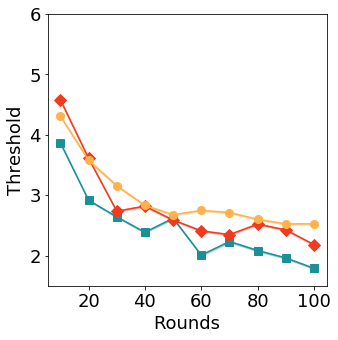

In [27]:

curve_w = params_weak.mean()[["%s%d" % t for t in zip([param] * 10, [x*10 for x in range(1, 10+1)])]]
curve_f = params_fix.mean()[["%s%d" % t for t in zip([param] * 10, [x*10 for x in range(1, 10+1)])]]
curve_c = params_chang.mean()[["%s%d" % t for t in zip([param] * 10, [x*10 for x in range(1, 10+1)])]]

weak = get_params(param, actions.loc[actions["score_adj"] <= -20, "user"], params_weak)
chang = get_params(param, actions.loc[actions["score_adj"] <= -20, "user"], params_chang)
fix = get_params(param, actions.loc[actions["score_adj"] <= -20, "user"], params_fix)

errWeak = weak["std"] / np.sqrt(5000)
errChang = chang["std"] / np.sqrt(5000)
errFix = fix["std"] / np.sqrt(5000)


plt.figure(figsize = (10,10))
plt.figure(figsize=(5,5))
plt.plot(weak["round"], weak[param],"-o",label = "Weak PD", color = pair_colors["weak"], marker = pair_symbols["weak"], markersize=8)
plt.plot(fix["round"], fix[param],"-o",label = "Fixed partners", color = pair_colors["fix"], marker = pair_symbols["fix"], markersize=8)
plt.plot(chang["round"], chang[param],"-o",label = "Shuffled partners", color = pair_colors["random"], marker = pair_symbols["random"], markersize=8)
plt.fill_between(weak["round"], weak[param] + (errWeak * 1.96), weak[param] - (errWeak * 1.96), alpha = 0.3, color = pair_colors["weak"])
plt.fill_between(fix["round"], fix[param] + (errFix * 1.96), fix[param] - (errFix * 1.96), alpha = 0.3, color = pair_colors["fix"])
plt.fill_between(chang["round"], chang[param] + (errChang * 1.96), chang[param] - (errChang * 1.96), alpha = 0.3, color = pair_colors["random"])
plt.xlabel("Rounds")
plt.ylabel("Threshold")
plt.ylim(1.5, 6)
#plt.legend()

<Figure size 720x720 with 0 Axes>

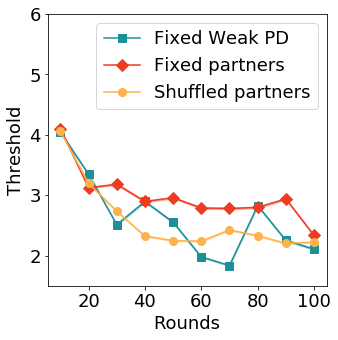

In [59]:
weak = get_params(param, actions.loc[actions["score_adj"] >= 20, "user"], params_weak)
chang = get_params(param, actions.loc[actions["score_adj"] >= 20, "user"], params_chang)
fix = get_params(param, actions.loc[actions["score_adj"] >= 16, "user"], params_fix)

errWeak = weak["std"] / np.sqrt(5000)
errChang = chang["std"] / np.sqrt(5000)
errFix = fix["std"] / np.sqrt(5000)


plt.figure(figsize = (10,10))
plt.figure(figsize=(5,5))
plt.plot(weak["round"], weak[param],"-o",label = "Fixed Weak PD", color = pair_colors["weak"], marker = pair_symbols["weak"], markersize=8)
plt.plot(fix["round"], fix[param],"-o",label = "Fixed partners", color = pair_colors["fix"], marker = pair_symbols["fix"], markersize=8)
plt.plot(chang["round"], chang[param],"-o",label = "Shuffled partners", color = pair_colors["random"], marker = pair_symbols["random"], markersize=8)
plt.fill_between(weak["round"], weak[param] + (errWeak * 1.96), weak[param] - (errWeak * 1.96), alpha = 0.3, color = pair_colors["weak"])
plt.fill_between(fix["round"], fix[param] + (errFix * 1.96), fix[param] - (errFix * 1.96), alpha = 0.3, color = pair_colors["fix"])
plt.fill_between(chang["round"], chang[param] + (errChang * 1.96), chang[param] - (errChang * 1.96), alpha = 0.3, color = pair_colors["random"])
plt.xlabel("Rounds")
plt.ylabel("Threshold")
plt.ylim(1.5, 6)
plt.legend()

(array([ 7., 17., 21., 10., 12., 12.,  9.,  2.,  4.,  2.]),
 array([-176. , -129.6,  -83.2,  -36.8,    9.6,   56. ,  102.4,  148.8,
         195.2,  241.6,  288. ]),
 <a list of 10 Patch objects>)

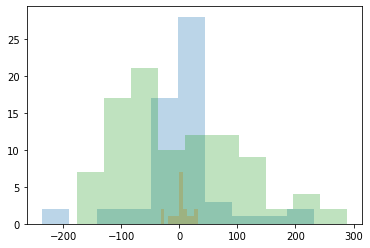

In [46]:
plt.hist(params_fix.score_adj, alpha = 0.3)
plt.hist(params_weak.score_adj, alpha = 0.3)
plt.hist(params_chang.score_adj, alpha = 0.3)

In [84]:
players = data.loc[data.treatment == "fix", ["player", "opponent"]]
players = players.drop_duplicates(subset = ["player", "opponent"])
players = players.merge(actions[["user", "type", "type_adj"]], left_on = "player", right_on = "user")
del players["user"]
players['opponent'] = players['opponent'].apply(lambda x: x.replace("['","").replace("']","")) 
players = players.merge(actions[["user", "type", "type_adj"]], left_on = "opponent", right_on = "user")
del players["user"]

<Figure size 720x720 with 0 Axes>

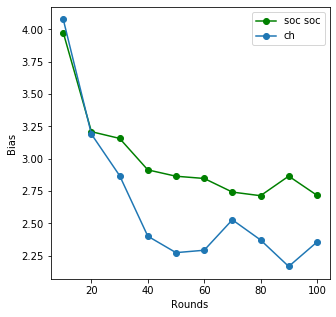

In [92]:
param = "a"
soc_soc = get_params(param, players.loc[(players.type_adj_x == "Pro-social") & (players.type_x == "Pro-social"), "player"], params_fix)
soc_soc_ch = get_params(param, actions.loc[(actions.type_adj == "Pro-social") & (actions["type"] == "Pro-social"), "user"], params_chang)
#soc_sel = get_params(param, players.loc[(players.type_adj_x == "Pro-social") & (players.type_y == "Pro-self"), "player"], params_fix)
#sel_soc = get_params(param, players.loc[(players.type_adj_x == "Pro-self") & (players.type_y == "Pro-social"), "player"], params_fix)
#sel_sel = get_params(param, players.loc[(players.type_adj_x == "Pro-self") & (players.type_x == "Pro-self"), "player"], params_fix)
#errWeak = selwe["std"] / np.sqrt(5000)
#errChang = selch["std"] / np.sqrt(5000)
#errFix = selfix["std"] / np.sqrt(5000)

plt.figure(figsize = (10,10))
plt.figure(figsize=(5,5))
plt.plot(soc_soc["round"], soc_soc[param],"-o",label = "soc soc", color = "green")
plt.plot(soc_soc_ch["round"], soc_soc_ch[param],"-o",label = "ch")
#plt.plot(soc_sel["round"], soc_sel[param],"-o",label = "soc sel", color = "blue")
#plt.plot(sel_soc["round"], sel_soc[param],"-o",label = "sel soc", color = "orange")
#plt.plot(sel_sel["round"], sel_soc[param],"-o",label = "sel sel", color = "red")
#plt.fill_between(selwe["round"], selwe[param] + (errWeak * 1.96), selwe[param] - (errWeak * 1.96), alpha = 0.3, color = "green")
#plt.fill_between(selfix["round"], selfix[param] + (errFix * 1.96), selfix[param] - (errFix * 1.96), alpha = 0.3, color = "blue")
#plt.fill_between(selch["round"], selch[param] + (errChang * 1.96), selch[param] - (errChang * 1.96), alpha = 0.3, color = "orange")
plt.xlabel("Rounds")
plt.ylabel("Bias")
plt.legend()

10     s4m8_usuario5
14     s8n3_usuario4
20     s8n3_usuario5
27     s8n3_usuario3
31    s8n3_usuario15
35    s9n3_usuario12
38     s9n3_usuario3
41    s9n3_usuario11
42    s9n3_usuario16
45     s9n3_usuario1
46    s9n3_usuario17
51    s10n5_usuario6
52    s10n5_usuario8
56    s10n5_usuario7
Name: player, dtype: object

In [74]:
players = data.loc[data.treatment == "changing", ["player", "opponent"]]
players = players.drop_duplicates(subset = ["player", "opponent"])
players = players.merge(actions[["user", "type", "type_adj"]], left_on = "player", right_on = "user")
del players["user"]
players['opponent'] = players['opponent'].apply(lambda x: x.replace("['","").replace("']","")) 
players = players.merge(actions[["user", "type", "type_adj"]], left_on = "opponent", right_on = "user")
del players["user"]
players

,player,opponent,type_x,type_adj_x,type_y,type_adj_y
0,s5m20_usuario1,s5m20_usuario12,Pro-self,Pro-social,Pro-self,Pro-self
1,s5m20_usuario2,s5m20_usuario12,Pro-self,Pro-self,Pro-self,Pro-self
2,s5m20_usuario3,s5m20_usuario12,Pro-social,Pro-social,Pro-self,Pro-self
3,s5m20_usuario4,s5m20_usuario12,Pro-self,Pro-social,Pro-self,Pro-self
4,s5m20_usuario5,s5m20_usuario12,Pro-social,Pro-social,Pro-self,Pro-self
...,...,...,...,...,...,...
1483,s12n11_usuario14,s12n11_usuario1,Pro-self,Pro-self,Pro-social,Pro-social
1484,s12n11_usuario15,s12n11_usuario1,Pro-social,Pro-social,Pro-social,Pro-social
1485,s12n11_usuario16,s12n11_usuario1,Pro-self,Pro-self,Pro-social,Pro-social
1486,s12n11_usuario17,s12n11_usuario1,Pro-social,Pro-social,Pro-social,Pro-social


In [76]:
players.loc[(players.type_adj_x == "Pro-social"), "type_y"].value_counts()

Pro-self      523
Pro-social    132
Name: type_y, dtype: int64

In [82]:
params_fix.loc[params_fix.type_adj == "Pro-self", "a"].mean()

3.418892017217391

In [81]:
params_chang.loc[params_chang.type_adj == "Pro-self", "a"].mean()

3.599771676320061